In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
from pathlib import Path 
import warnings
warnings.filterwarnings("ignore")
import pyreadr
import random
from sklearn.preprocessing import OneHotEncoder

In [1]:
import RFmodel
import FileProcessing
import warnings
warnings.filterwarnings("ignore")

In [2]:
model = RFmodel.ModelClass()                 
fileProcessing=FileProcessing.FileProcessing()

In [3]:
file_name='Cleaned_NGSIM_Data3'
ngsim1=fileProcessing.read_input(file_name)  

original File path: c:\Users\neels\Desktop\Capstone\carfollowing\DataDrivenCarFollowing\datadrivencarfollowing-v1\scripts
Data File path: c:\Users\neels\Desktop\Capstone\carfollowing\DataDrivenCarFollowing\datadrivencarfollowing-v1\data


In [23]:
ngsim = model.preprocessing(ngsim1,0.4)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


In [24]:
def prediction(test,unique_pairs_df,rf,delta_time):
        predicted_df = []
        input_df = pd.DataFrame()
        # unique_pairs_df is the test range
        for i in unique_pairs_df:
            # Q this is the input data frame
            input_df = test[test['L-F_Pair']== i]
            spacing = np.zeros(input_df.shape[0])
            local_y_subject = np.zeros(input_df.shape[0])
            local_y_preceding = np.zeros(input_df.shape[0])
            dv = np.zeros(input_df.shape[0])
            vel = np.zeros(input_df.shape[0])
            pred_acc = np.zeros(input_df.shape[0])

            vel[0] = input_df.iloc[0]['v_Vel']
            spacing[0] = input_df.iloc[0]['Rear_to_Front_Space_Headway']
            dv[0] = input_df.iloc[0]['Velocity Difference_Following-Preceding']

            local_y_subject[0] = input_df.iloc[0]['Local_Y']
            local_y_preceding[0] = input_df.iloc[0]['previous_Local_Y']
            preceding_vehicle_class = input_df.iloc[0]['PrecVehType']
            vehicle_class = input_df.iloc[0]['Vehicle.type']
            length_preceding_vehicle = input_df.iloc[0]['preceding_vehicle_length']

            predict_for_input = np.array(
                [spacing[0], preceding_vehicle_class, vehicle_class, dv[0], vel[0]]).reshape(1, -1)
            pred_acc[0] = rf.predict(predict_for_input)
            print(
                f"j: {0} input:{predict_for_input},subject localy:{local_y_subject[0]},preceding_local_y:{local_y_preceding[0]},spacing:{spacing[0]} pred_acc: {pred_acc[0]}")
            vel[1] = vel[0]+(pred_acc[0]*delta_time)


            dv[1] = vel[1] - input_df.iloc[1]['previous_Vehicle_Velocity']

            s_subject = ((vel[0]*delta_time ) +
                            (0.5*pred_acc[0]*pow(delta_time, 2)))
                            #should be 1  second here

            local_y_subject[1] = local_y_subject[0] + s_subject
            local_y_preceding[1] = input_df.iloc[1]['previous_Local_Y'] 

            spacing[1] = local_y_preceding[1] - \
                local_y_subject[1] - length_preceding_vehicle

            for j in range(1, len(input_df)):
                predict_for_input = np.array(
                    [spacing[j], preceding_vehicle_class, vehicle_class, dv[j], vel[j]]).reshape(1, -1)
                
                pred_acc[j] = rf.predict(predict_for_input)
                if j == len(input_df)-1:
                    break
                
                vel[j+1] = vel[j]+(pred_acc[j]*0.1)


                dv[j+1] = vel[j+1] - input_df.iloc[j+1]['previous_Vehicle_Velocity']


                s_subject = ((vel[j]*0.1) +
                                (0.5*pred_acc[j]*pow(0.1, 2)))
                                

                
                local_y_subject[j+1] = local_y_subject[j] + s_subject
                local_y_preceding[j+1] = input_df.iloc[j+1]['previous_Local_Y']

                spacing[j+1] = local_y_preceding[j+1] - \
                    local_y_subject[j+1] - length_preceding_vehicle

                print(f"j: {j} input:{predict_for_input},subject localy:{local_y_subject[j]},preceding_local_y:{local_y_preceding[j]},spacing:{spacing[j]} pred_acc: {pred_acc[j]}")

            print(f"input_df shape: {input_df.shape}")
            print(f"pred_acc shape: {pred_acc.shape}")
            input_df['predicted_acceleration'] = pred_acc
            input_df['predicted_velocity'] = vel
            input_df['predicted_spacing'] = spacing

            predicted_df.append(input_df)
            result = pd.concat(predicted_df)
            #r.append(r2_score(Q[target_variable], Q['pacc']))      
        return result

In [25]:
F = prediction(test,['1978-1984'],rf,0.4)

j: 0 input:[[ 8.543544  2.        2.        0.170688 11.94816 ]],subject localy:30.802,preceding_local_y:70.827,spacing:8.543544 pred_acc: 0.08006757333333328
j: 1 input:[[35.39173059  2.          2.          0.52885103 11.98018703]],subject localy:35.58766940586666,preceding_local_y:74.637,spacing:35.391730594133335 pred_acc: 0.1604263999999999
j: 2 input:[[37.85390976  2.          2.          0.77349367 11.99622967]],subject localy:36.7864902408,preceding_local_y:78.298,spacing:37.8539097592 pred_acc: 0.70648576
j: 3 input:[[40.26075436  2.          2.          0.88986225 12.06687825]],subject localy:37.98964563653333,preceding_local_y:81.908,spacing:40.26075436346667 pred_acc: -0.6893153599999993
j: 4 input:[[42.71851312  2.          2.          0.74473071 11.99794671]],subject localy:39.19288688426666,preceding_local_y:85.569,spacing:42.71851311573334 pred_acc: 0.6956145599999999
j: 5 input:[[45.24924037  2.          2.          0.73504417 12.06750817]],subject localy:40.396159628,

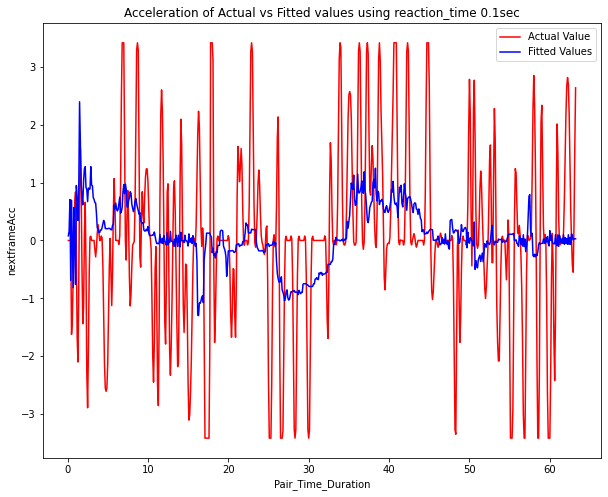

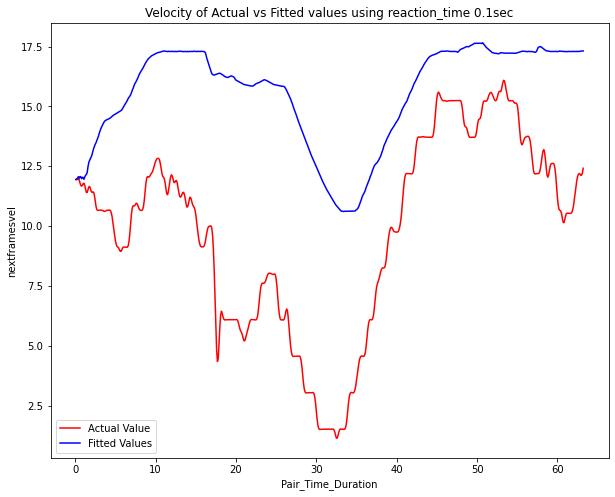

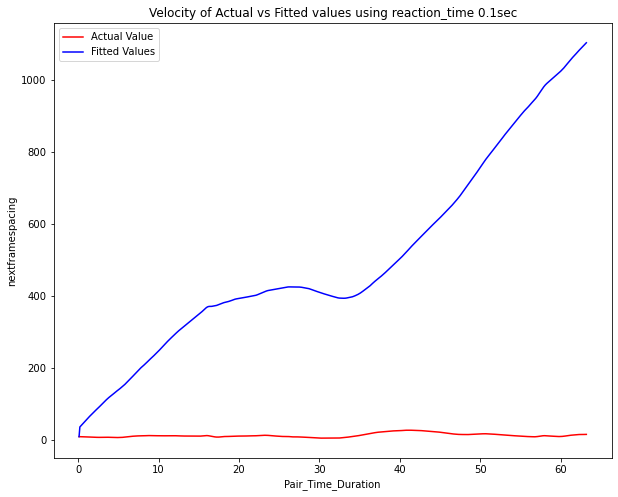

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [26]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','predicted_acceleration','Acceleration of Actual vs Fitted values using reaction_time 0.1sec')
model.plot_1(F1,'nextframesvel','predicted_velocity', 'Velocity of Actual vs Fitted values using reaction_time 0.1sec')
model.plot_1(F1,'nextframespacing','predicted_spacing', 'Velocity of Actual vs Fitted values using reaction_time 0.1sec')

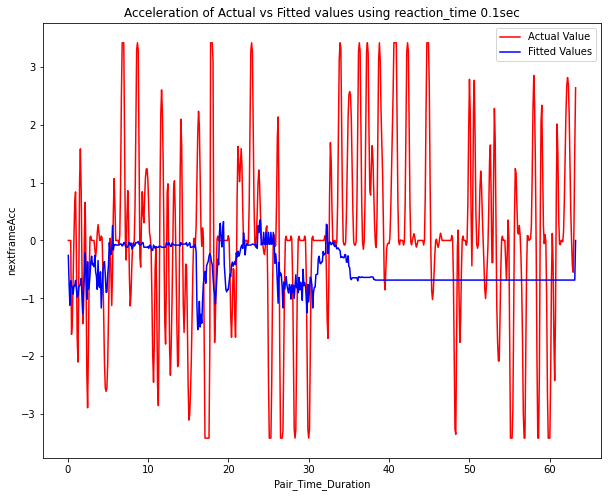

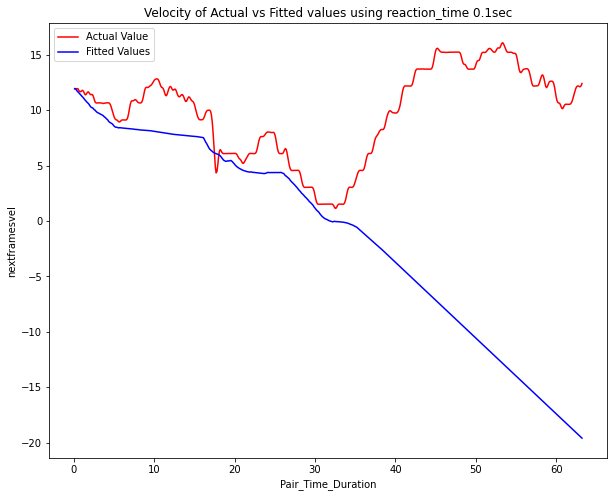

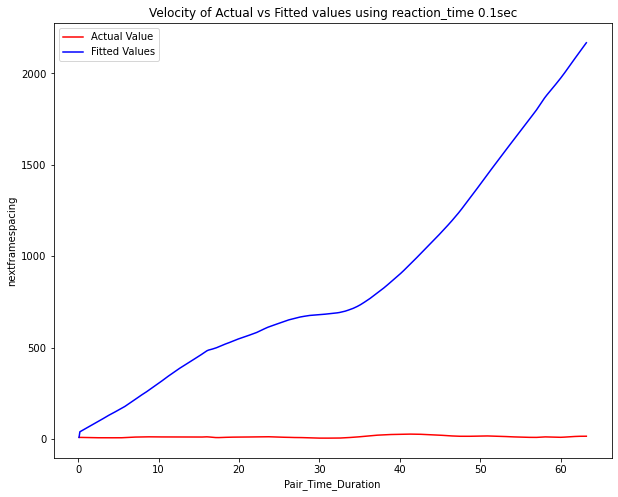

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [8]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.1sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.1sec')
model.plot_1(F1,'nextframespacing','pspacing', 'Velocity of Actual vs Fitted values using reaction_time 0.1sec')

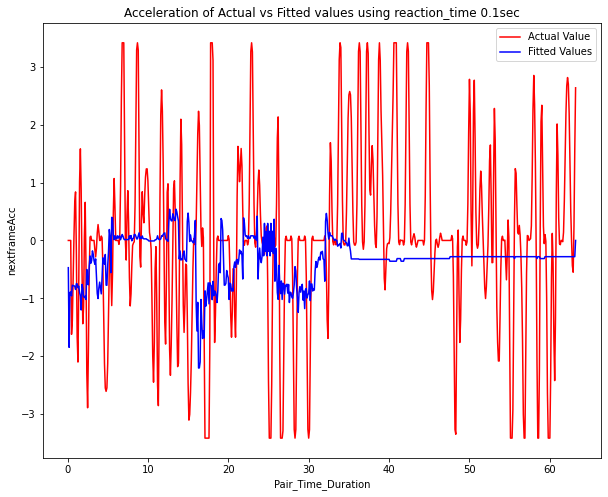

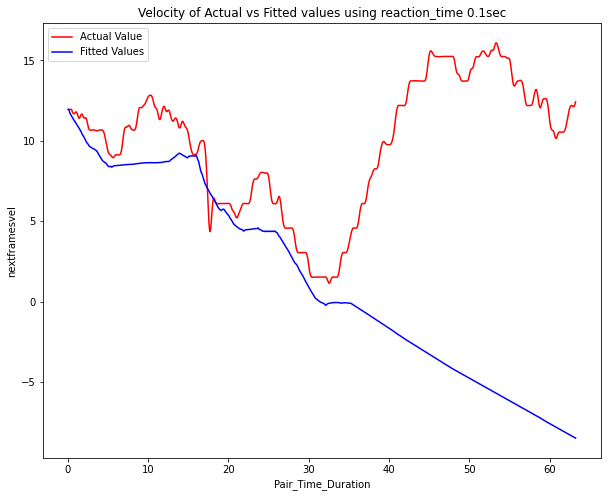

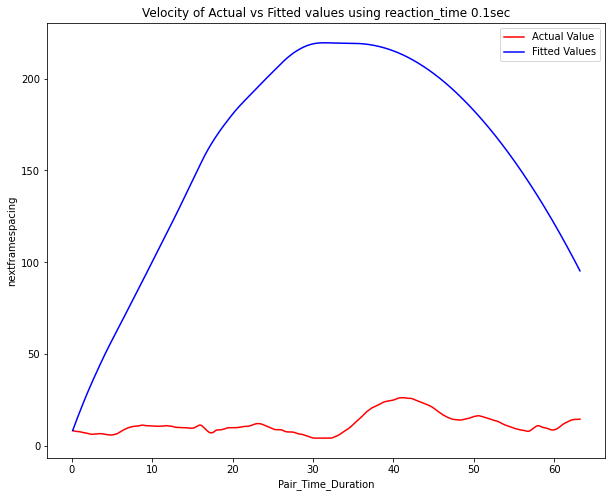

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [8]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.1sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.1sec')
model.plot_1(F1,'nextframespacing','pspacing', 'Velocity of Actual vs Fitted values using reaction_time 0.1sec')

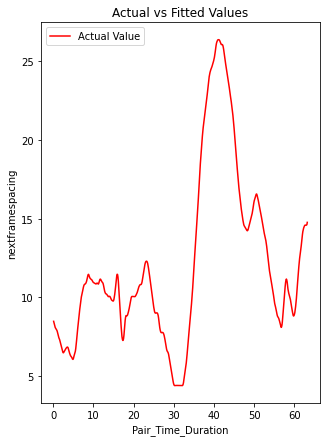

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 7))


ax = sns.lineplot(x=F1["Pair_Time_Duration"], y = F1["nextframespacing"], color="r", label="Actual Value")


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [6]:
ngsim = model.preprocessing(ngsim1,0.4)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)
F = model.prediction(test,p,'nextframeAcc',rf,0.4)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


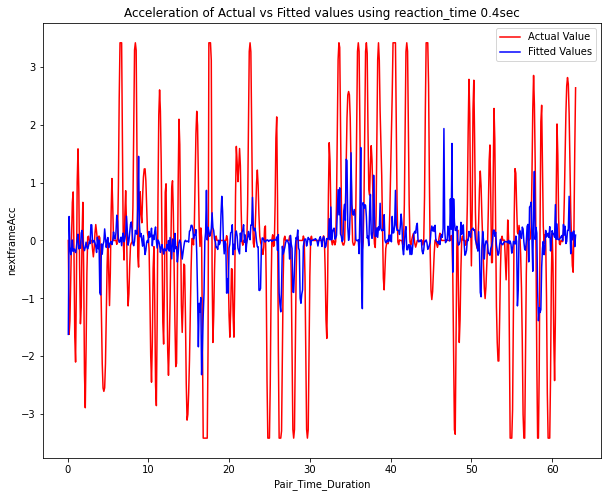

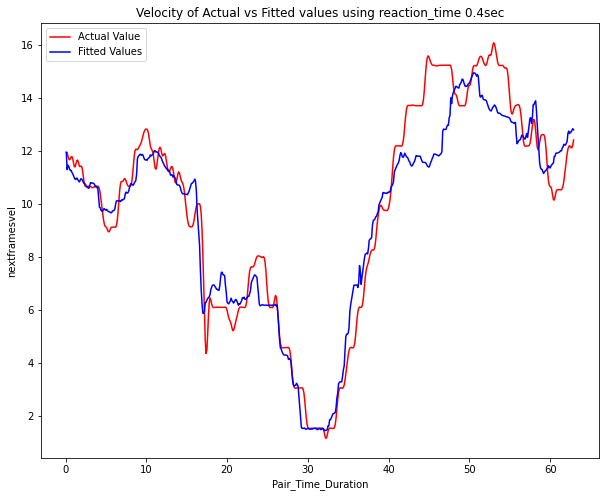

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [7]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.4sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.4sec')

In [8]:
ngsim = model.preprocessing(ngsim1,0.5)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)
F = model.prediction(test,p,'nextframeAcc',rf,0.5)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


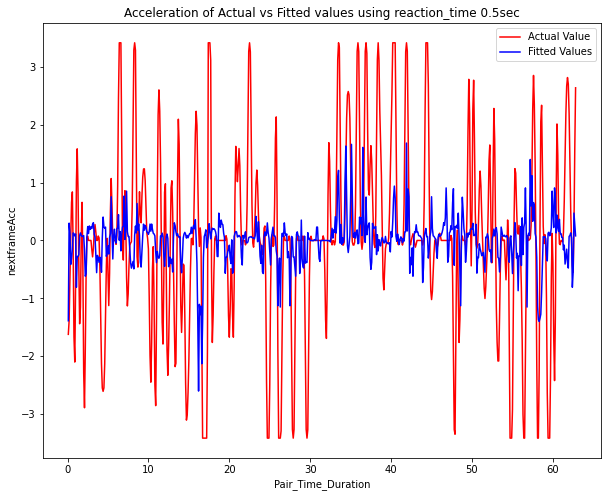

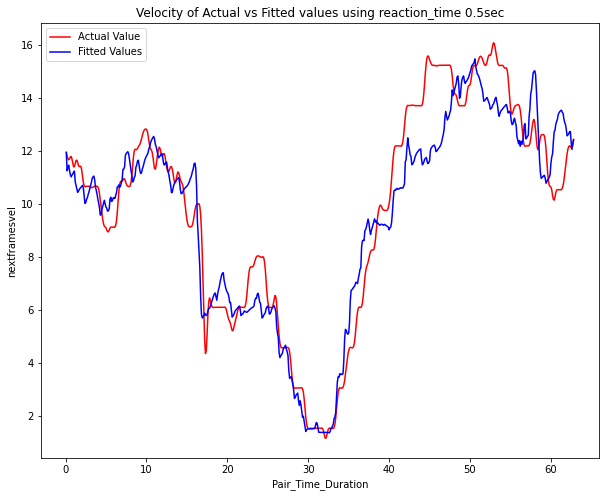

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.5sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.5sec')

In [10]:
ngsim = model.preprocessing(ngsim1,0.8)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)
F = model.prediction(test,p,'nextframeAcc',rf,0.8)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


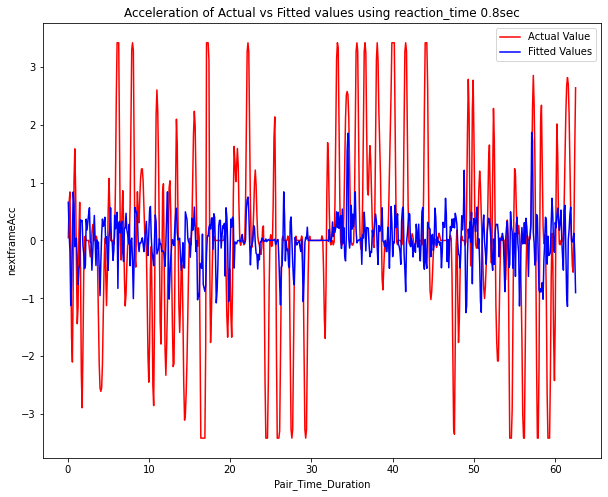

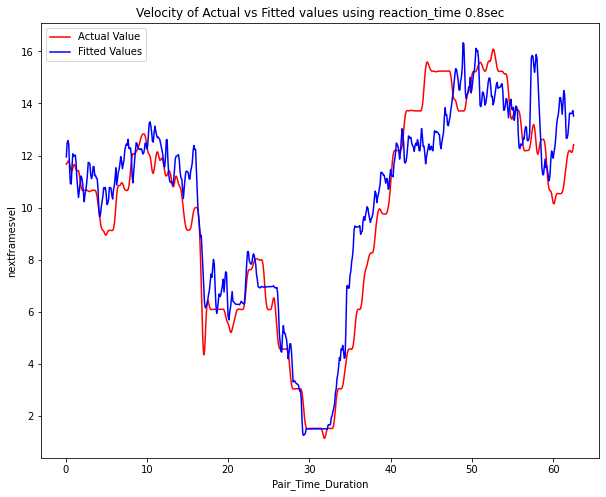

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.8sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.8sec')

In [12]:
ngsim = model.preprocessing(ngsim1,1)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)
F = model.prediction(test,p,'nextframeAcc',rf,1)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


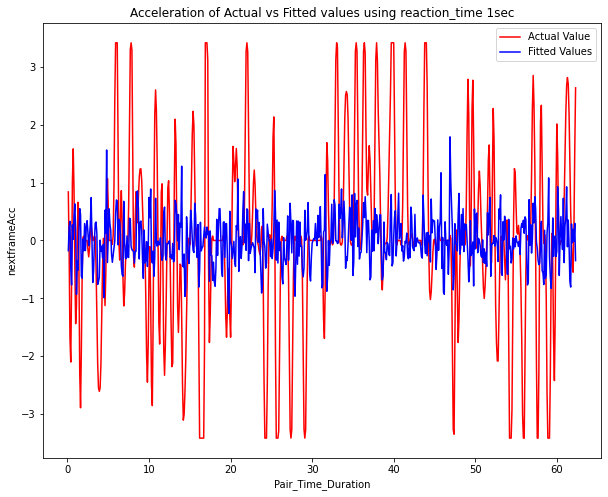

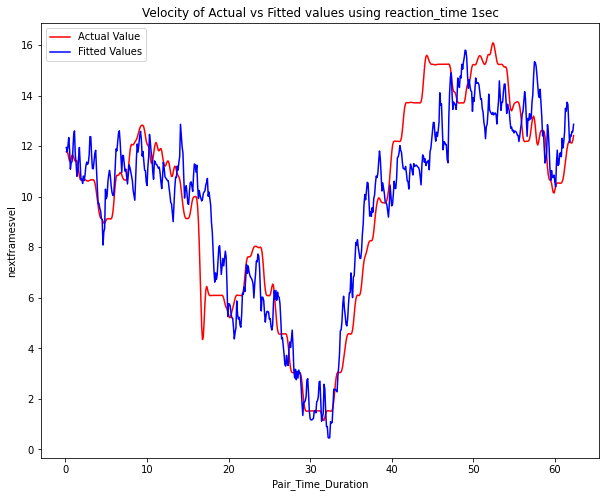

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [13]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 1sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 1sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 1sec')